In [1]:
%matplotlib inline
import cv2 as cv
import os 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.image as mpimg
import shutil
import random

In [2]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dropout, Dense
from keras.preprocessing import image as kimage
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam
from keras.applications import mobilenet_v2
from keras.applications import vgg16
from keras.applications import resnet50

Using TensorFlow backend.


In [3]:
#scaricare da github
face_detector = cv.CascadeClassifier('haarcascade_frontalface_default.xml')

In [4]:
if not os.path.exists('./ImageRec'):
    os.makedirs('./ImageRec')

In [5]:
root_dir = './ImageRec'

In [11]:
def video_to_img(video_path, n_class):
    
    cam = cv.VideoCapture(video_path)
    if not os.path.exists('./ImageRec/' + n_class):
        os.makedirs('./ImageRec/' + n_class)
    currentframe = 0
    
    while(True): 
        
        ret,frame = cam.read() 
        if ret: 
            faces = face_detector.detectMultiScale(frame) 
            if len(faces) == 1:
                for (x,y,w,h) in faces:
                    face = frame[y:y+h,x:x+h,:]
                face=cv.resize(face, (224,224)) #lasciare o togliere?    
                name = './ImageRec/'+ n_class + '/frame' + str(currentframe) + str(n_class) + '.jpg'
                print ('Creating...' + name) 
  
                cv.imwrite(name, face) 
  
            currentframe += 1
        else: 
            break
  
    cam.release() 
    cv.destroyAllWindows() 
    
    

Inserire un video con il volto da riconoscere e il numero della classe (numero della persona da riconoscere)

In [108]:
video_to_img('videom.mp4', 'classe1')

In [107]:
video_to_img('roberto_3.webm', 'classe2')

In [106]:
#video_to_img('roberto_video_faccia.webm', 'classe3')

In [15]:
def augment_brightness_camera_images(image):
    image1 = cv.cvtColor(image,cv.COLOR_RGB2HSV)
    random_bright = 0.25+np.random.uniform()
    image1[:,:,2] = image1[:,:,2]*random_bright
    image1 = cv.cvtColor(image1,cv.COLOR_HSV2RGB)
    return image1

def transform_image(img,ang_range,shear_range,trans_range,brightness=0):
    '''
    This function transforms images to generate new images.
    The function takes in following arguments,
    1- Image
    2- ang_range: Range of angles for rotation
    3- shear_range: Range of values to apply affine transform to
    4- trans_range: Range of values to apply translations over.

    A Random uniform distribution is used to generate different parameters for transformation

    '''
    # Rotation

    ang_rot = np.random.uniform(ang_range)-ang_range/2
    rows,cols,ch = img.shape    
    Rot_M = cv.getRotationMatrix2D((cols/2,rows/2),ang_rot,1)

    # Translation
    tr_x = trans_range*np.random.uniform()-trans_range/2
    tr_y = trans_range*np.random.uniform()-trans_range/2
    Trans_M = np.float32([[1,0,tr_x],[0,1,tr_y]])

    # Shear
    pts1 = np.float32([[5,5],[20,5],[5,20]])

    pt1 = 5+shear_range*np.random.uniform()-shear_range/2
    pt2 = 20+shear_range*np.random.uniform()-shear_range/2

    # Brightness


    pts2 = np.float32([[pt1,5],[pt2,pt1],[5,pt2]])

    shear_M = cv.getAffineTransform(pts1,pts2)

    img = cv.warpAffine(img,Rot_M,(cols,rows))
    img = cv.warpAffine(img,Trans_M,(cols,rows))
    img = cv.warpAffine(img,shear_M,(cols,rows))

    if brightness == 1:
        img = augment_brightness_camera_images(img)

    return img

In [16]:
def image_augmentation(path):
    for foto in os.listdir(path):
        img = mpimg.imread(os.path.join(path, foto))
        for i in range(1):
            #imgg = transform_image(img,10,5,3,brightness=1)
            imgg = augment_brightness_camera_images(img)
            copia_foto = path + '/' + foto.rpartition('.jpg')[0] + 'copia' + str(i+1) + '.jpg'
            mpimg.imsave(copia_foto, imgg)
            print ('Creating...' + copia_foto ) 
    

In [17]:
#image_augmentation('./ImageRec/add3')

In [104]:
for subdir in os.listdir(root_dir):
    image_augmentation(os.path.join(root_dir, subdir))

In [19]:
classes = [name for name in os.listdir(root_dir)]

In [20]:
classes

['classe1', 'classe2', 'classe3']

In [21]:
if not os.path.exists(root_dir +'/train'):
    os.makedirs(root_dir +'/train')
if not os.path.exists(root_dir +'/test'):    
    os.makedirs(root_dir +'/test')

In [22]:
for cls in classes:
    
    if not os.path.exists(root_dir +'/train/' + cls):
        os.makedirs(root_dir +'/train/' + cls)
    if not os.path.exists(root_dir +'/test/' + cls):     
        os.makedirs(root_dir +'/test/' + cls)
    
    src = root_dir + '/' + cls 

    allFileNames = os.listdir(src)
    np.random.shuffle(allFileNames)
    train_FileNames, test_FileNames = np.split(np.array(allFileNames), [int(len(allFileNames)*(0.8))])

    
    
    train_FileNames = [src+'/'+ name for name in train_FileNames.tolist()]
    test_FileNames = [src+'/' + name for name in test_FileNames.tolist()]

    print('Total images: ', len(allFileNames))
    print('Training: ', len(train_FileNames))
    print('Testing: ', len(test_FileNames))

    # Copy-pasting images
    for name in train_FileNames:
        shutil.copy(name, root_dir +'/train/' + cls)

    for name in test_FileNames:
        shutil.copy(name, root_dir +'/test/' + cls)

Total images:  1027
Training:  821
Testing:  206
Total images:  1212
Training:  969
Testing:  243
Total images:  678
Training:  542
Testing:  136


In [23]:
#mobilenet = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet', pooling='avg', input_shape=(224, 224, 3))

In [24]:
vgg = vgg16.VGG16(input_shape=(224,224,3), weights='imagenet', include_top=False, pooling='avg')

In [25]:
#mobilenet = resnet50.ResNet50(include_top=False, weights='imagenet', pooling='max',  input_shape=(224, 224, 3))

In [26]:
train_preprocessing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input, 
                                     horizontal_flip=True,         #horizontal flip
                                     width_shift_range=0.2,        #width shifting
                                     height_shift_range=0.2,       #height shifting
                                     #brightness_range = (0.4,1.5), #brightness shifting
                                     zoom_range = [0.5,1.0],       #Random Zoom
                                     rotation_range=90
                                     )

In [31]:
#train_preprocessing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

In [27]:
train_generator = train_preprocessing.flow_from_directory(
    directory='./ImageRec/train',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=1
    )


Found 2332 images belonging to 3 classes.


In [28]:
test_preprocessing = kimage.ImageDataGenerator(preprocessing_function=vgg16.preprocess_input)

In [29]:
test_generator = test_preprocessing.flow_from_directory(
    directory='./ImageRec/test',
    target_size=(224,224),
    color_mode='rgb',
    batch_size=32,
    class_mode='categorical',
    shuffle=True,
    seed=1
    )

Found 585 images belonging to 3 classes.


In [30]:
for layer in vgg.layers:
    layer.trainable = False

In [31]:
x = vgg.output
x = Dense(1024, activation='relu')(x)
pred = Dense(3, activation='softmax')(x) 

net = Model(inputs=vgg.input, output=pred)

c:\users\marco\appdata\local\programs\python\python37\lib\site-packages\ipykernel_launcher.py:5: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("de...)`
  """


In [32]:
net.compile(loss=keras.losses.categorical_crossentropy,
            optimizer=Adam(),#keras.optimizers.RMSprop(), #Adam()
            metrics=['accuracy'])

In [33]:
epochs = 10
steps_per_epoch = 10

early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    verbose=1,
    patience=3,
    mode='max',
    restore_best_weights=True)

In [34]:
results = net.fit_generator(
    train_generator,
    epochs=epochs, steps_per_epoch=steps_per_epoch,
    validation_data=test_generator,
    callbacks = [early_stopping]
    )

Epoch 1/10
10/10 [==============================] - 190s 19s/step - loss: 1.2297 - accuracy: 0.6875 - val_loss: 0.3033 - val_accuracy: 0.9350
Epoch 2/10
10/10 [==============================] - 200s 20s/step - loss: 0.2398 - accuracy: 0.9156 - val_loss: 0.0216 - val_accuracy: 0.9470
Epoch 3/10
10/10 [==============================] - 195s 19s/step - loss: 0.1346 - accuracy: 0.9563 - val_loss: 0.4720 - val_accuracy: 0.9316
Epoch 4/10
10/10 [==============================] - 194s 19s/step - loss: 0.0814 - accuracy: 0.9688 - val_loss: 0.1261 - val_accuracy: 0.9060
Epoch 5/10
10/10 [==============================] - 194s 19s/step - loss: 0.0475 - accuracy: 0.9747 - val_loss: 3.6759e-04 - val_accuracy: 0.9726
Epoch 6/10
10/10 [==============================] - 194s 19s/step - loss: 0.0242 - accuracy: 0.9937 - val_loss: 0.2086 - val_accuracy: 0.9607
Epoch 7/10
10/10 [==============================] - 195s 19s/step - loss: 0.0569 - accuracy: 0.9875 - val_loss: 0.0070 - val_accuracy: 0.9607
Ep

In [47]:
net.save('retevgg3classi17.h5')

In [36]:
plt.rcParams['figure.figsize'] = (18, 12)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

def plot_metrics(history):
    metrics =  ['loss', 'accuracy']
    for n, metric in enumerate(metrics):
        name = metric.replace("_"," ").capitalize()
        plt.subplot(2,2,n+1)
        plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
        plt.plot(history.epoch, history.history['val_'+metric], color=colors[0], linestyle="--", label='Test')
        plt.xlabel('Epoch')
        plt.ylabel(name)
        if metric == 'loss':
            plt.ylim([0, plt.ylim()[1]])
        elif metric == 'accuracy':
            plt.ylim([0.2,1])
        else:
            plt.ylim([0,1])

        plt.legend()

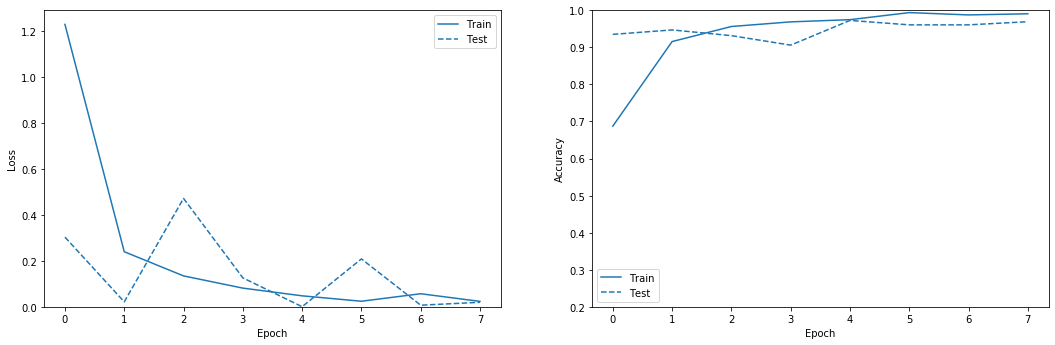

In [37]:
plot_metrics(results)

In [5]:
#net = keras.models.load_model('retevgg3classi.h5')

In [42]:
names = ['Marco' ,'Roberto', '???']

Prova con foto scattata da webcam

In [70]:
cap = cv.VideoCapture(0)
# Acquisizione immagine
result, img = cap.read()
# Rilascio del dispositivo
cap.release()

In [71]:
b,g,r = cv.split(img)
img = cv.merge([r,g,b])
faces = face_detector.detectMultiScale(img)
print(len(faces))
for (x,y,w,h) in faces:
        face = img[y:y+h,x:x+h,:]

1


In [101]:
plt.imshow(face), plt.show()

In [73]:
img_pixels = cv.resize(face, (224, 224)) 
img_pixels = kimage.img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels = vgg16.preprocess_input(img_pixels)
y_pred = net.predict(img_pixels)
y_pred_name = np.argmax(y_pred)
names[y_pred_name]

'Marco'

In [74]:
y_pred

array([[9.9998879e-01, 1.1579524e-06, 9.9987183e-06]], dtype=float32)

Prova con foto caricata

In [95]:
img = mpimg.imread('marco.jpg')

1


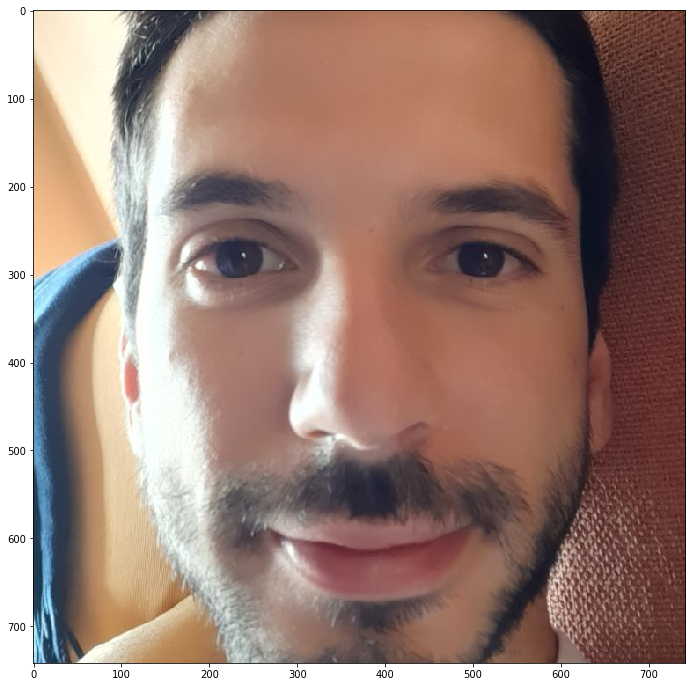

In [96]:
faces = face_detector.detectMultiScale(img)
print(len(faces))
for (x,y,w,h) in faces:
        face = img[y:y+h,x:x+h,:]
        
plt.imshow(face); plt.show()        

In [50]:
#def soglia (y_pred):
#    if np.max(y_pred) < 0.65:
#        return "???" + str(int(np.max(y_pred)* 100))+'%'
#    else:
#        y_pred_name = np.argmax(y_pred)
#        return names[y_pred_name] + str(int(np.max(y_pred)* 100))+'%'

In [97]:
img_pixels = cv.resize(face, (224, 224)) 
img_pixels = kimage.img_to_array(img_pixels)
img_pixels = np.expand_dims(img_pixels, axis = 0)
img_pixels = vgg16.preprocess_input(img_pixels)
y_pred = net.predict(img_pixels)
y_pred_name = np.argmax(y_pred)
names[y_pred_name]

'Marco'

In [13]:
y_pred

array([[6.006947e-01, 3.622074e-14, 3.993053e-01]], dtype=float32)

In [101]:
#y_dist = net.predict(img_pixels)
#y_dist[0][1] = min(y_dist[0][1], 0.9876)
#y_pred = np.argmax(y_dist)
#y_dist = y_dist[0, y_pred]

#if(y_dist > 0.75):
#    real_names.append((names[y_pred], round(y_dist, 4)))
#else:
#    real_names.append(('unknown\n', round(1-y_dist, 4)))
            

Prova con video da webcam

In [99]:
def process_frame(img):
    if img is not None:
        #img_gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        faces = face_detector.detectMultiScale(img)
        if len(faces)>=1:
            (x,y,w,h) = faces[0]
            face = img[y:y+h, x:x+w, :]
            img_pixels = cv.resize(face, (224, 224)) 
            img_pixels = kimage.img_to_array(img_pixels)
            img_pixels = np.expand_dims(img_pixels, axis = 0)
            img_pixels = vgg16.preprocess_input(img_pixels)
            y_pred = net.predict(img_pixels)
            y_pred_name = np.argmax(y_pred)
           # names[y_pred_name]
            #y_dist = net.predict(img_pixels)
            #y_dist[0][1] = min(y_dist[0][1]+0.4, 0.9876)
            #y_pred = np.argmax(y_dist)
            #y_dist = y_dist[0, y_pred]

            #if(np.max(y_pred)) > 0.75:
            #    testo = names[y_pred_name] + str(np.max(y_pred))
                #real_names.append((names[y_pred], round(y_dist, 4)))
            #else:
             #   testo = '???' + str(np.max(y_pred))
                #real_names.append(('unknown\n', round(1-y_dist, 4)))
           # y_pred = net.predict(img_pixels)
            #y_pred_name = np.argmax(y_pred)
            testo = names[y_pred_name] + ' ' + str(int(np.max(y_pred)* 100))+'%'
            
            cv.rectangle(img,(x,y),(x+w,y+h),(0,255,0),2)
            cv.putText(img, testo, org = (100, 185), fontScale = 1, fontFace = cv.FONT_HERSHEY_SIMPLEX, 
                       color = (0, 0, 255), thickness = 2)
    
    return img #di base valori da 0 e 1, se metto 1 - ho l'inverso

In [100]:
cap = cv.VideoCapture(0)
while(True): # while infinito
    # Acquisizione nuovo frame
    r, frame = cap.read() #catturiamo un elemento
    # Elaborazione del contenuto
    frame = process_frame(frame) # ci si fa qualcosa (es quello per il progetto)
    # Visualizzazione esterna
    cv.imshow('Video', frame) #apre ina nuova finestra con il contenuto di quello che abbbiamo
    # Interruzione alla pressione del tasto Q
    if cv.waitKey(20) & 0xFF == ord('q'):
        break
cap.release() #rilascio il dispositivo
cv.destroyAllWindows() #chido la finestra